In [1]:
import os
import glob
import numpy as np
import xarray as xr
import rioxarray
from pyproj import Geod
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import folium
from folium import plugins
import geopandas as gpd
from shapely.geometry import Polygon
import json

dataset_dir = f"{os.path.dirname(os.getcwd())}/datasets"

In [2]:
# Load ocean current data
current_files = sorted(glob.glob(f"{dataset_dir}/realtime_surface_ocean_currents/oscar_currents_nrt_*.nc"))
print(f"Found {len(current_files)} current data files")

# Open multi-file dataset
currents_ds = xr.open_mfdataset(current_files, engine="netcdf4", combine='nested', concat_dim='time')

# Set spatial reference using rioxarray (EPSG:4326 = WGS84)
currents_ds.rio.write_crs("EPSG:4326", inplace=True)

# Rename coordinates to standard names for consistency
if 'lon' in currents_ds.coords and 'lat' in currents_ds.coords:
    currents_ds = currents_ds.rename({'lon': 'longitude', 'lat': 'latitude'})

print(f"Time range: {currents_ds['time'].values[0]} to {currents_ds['time'].values[-1]}")
print(f"Spatial extent: lon [{currents_ds.longitude.min().values:.2f}, {currents_ds.longitude.max().values:.2f}], "
      f"lat [{currents_ds.latitude.min().values:.2f}, {currents_ds.latitude.max().values:.2f}]")
print(f"Shape: {currents_ds['ug'].shape}")
currents_ds

Found 10 current data files
Time range: 2025-09-22 00:00:00 to 2025-10-01 00:00:00
Spatial extent: lon [0.00, 359.75], lat [-89.75, 89.75]
Shape: (10, 1440, 719)
Time range: 2025-09-22 00:00:00 to 2025-10-01 00:00:00
Spatial extent: lon [0.00, 359.75], lat [-89.75, 89.75]
Shape: (10, 1440, 719)


/tmp/ipykernel_5224/4220538050.py:13: UserWarning: rename 'lon' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  currents_ds = currents_ds.rename({'lon': 'longitude', 'lat': 'latitude'})
/tmp/ipykernel_5224/4220538050.py:13: UserWarning: rename 'lat' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  currents_ds = currents_ds.rename({'lon': 'longitude', 'lat': 'latitude'})


<xarray.Dataset> Size: 331MB
Dimensions:      (time: 10, longitude: 1440, latitude: 719)
Coordinates:
    latitude     (latitude) float64 6kB dask.array<chunksize=(719,), meta=np.ndarray>
    longitude    (longitude) float64 12kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * time         (time) object 80B 2025-09-22 00:00:00 ... 2025-10-01 00:00:00
    spatial_ref  int64 8B 0
Data variables:
    u            (time, longitude, latitude) float64 83MB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
    v            (time, longitude, latitude) float64 83MB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
    ug           (time, longitude, latitude) float64 83MB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
    vg           (time, longitude, latitude) float64 83MB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_NRT_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2025-09-22T00:00:00
    time_coverage_end:          2025-09-22T23:59:59
    date_created:               2025-10-02

## Mesoscale Eddy Detection using Okubo-Weiss Parameter

The Okubo-Weiss parameter identifies coherent vortex structures (eddies) in the flow field:
- **W < 0**: Vorticity-dominated regions (eddies)
- **W > 0**: Strain-dominated regions (stretching/shearing flow)

In [3]:
def calculate_spatial_derivatives(ds, u_var='ug', v_var='vg', time_idx=0):
    """Calculate spatial derivatives of velocity components."""
    # Select time slice
    u = ds[u_var].isel(time=time_idx)
    v = ds[v_var].isel(time=time_idx)

    # Get coordinates
    lons = ds['longitude'].values
    lats = ds['latitude'].values

    # Calculate distances in meters
    R = 6371000  # Earth radius in meters
    dlon_deg = np.mean(np.gradient(lons))  # longitude spacing in degrees (constant)
    dlat_deg = np.mean(np.gradient(lats))  # latitude spacing in degrees (constant)

    # dx: distance per longitude step, varies with latitude
    dx_val = R * np.cos(np.radians(lats)) * (dlon_deg * np.pi / 180)
    dx = np.outer(np.ones(len(lons)), dx_val)  # shape (nlon, nlat)

    # dy: distance per latitude step, approximately constant
    dy_val = R * (dlat_deg * np.pi / 180)
    dy = np.full((len(lons), len(lats)), dy_val)  # shape (nlon, nlat)

    # Compute gradients
    du_dx = np.gradient(u.values, axis=0) / dx
    du_dy = np.gradient(u.values, axis=1) / dy
    dv_dx = np.gradient(v.values, axis=0) / dx
    dv_dy = np.gradient(v.values, axis=1) / dy

    return du_dx, du_dy, dv_dx, dv_dy, lons, lats

### Calculate velocity gradients and strain/vorticity fields

In [ ]:
# Calculate spatial derivatives for the latest time step
du_dx, du_dy, dv_dx, dv_dy, lons, lats = calculate_spatial_derivatives(currents_ds, time_idx=-1)

# Calculate strain rate components
S_n = du_dx - dv_dy  # Normal strain rate (s^-1)
S_s = dv_dx + du_dy  # Shear strain rate (s^-1)

# Calculate vorticity
zeta = dv_dx - du_dy  # Vertical vorticity (s^-1)

# Calculate Okubo-Weiss parameter
W = S_n**2 + S_s**2 - zeta**2

# Create xarray DataArrays
okubo_weiss = xr.DataArray(
    W,
    coords={'longitude': lons, 'latitude': lats},
    dims=['longitude', 'latitude'],
    name='okubo_weiss',
    attrs={
        'long_name': 'Okubo-Weiss parameter',
        'units': 's^-2',
        'description': 'W < 0: vorticity-dominated (eddies), W > 0: strain-dominated'
    }
)

vorticity = xr.DataArray(
    zeta,
    coords={'longitude': lons, 'latitude': lats},
    dims=['longitude', 'latitude'],
    name='vorticity',
    attrs={'long_name': 'Vertical vorticity', 'units': 's^-1'}
)
okubo_weiss

✓ Okubo-Weiss parameter calculated for latest time step
  Range: [-9.35e-09, 7.67e-09] s^-2
  Eddy-dominated regions (W < 0): 25.9%
  Strain-dominated regions (W > 0): 37.6%


<xarray.DataArray 'okubo_weiss' (longitude: 1440, latitude: 719)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(1440, 719))
Coordinates:
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float64 6kB -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
Attributes:
    long_name:    Okubo-Weiss parameter
    units:        s^-2
    description:  W < 0: vorticity-dominated (eddies), W > 0: strain-dominated

### Visualize eddy fields for latest time step

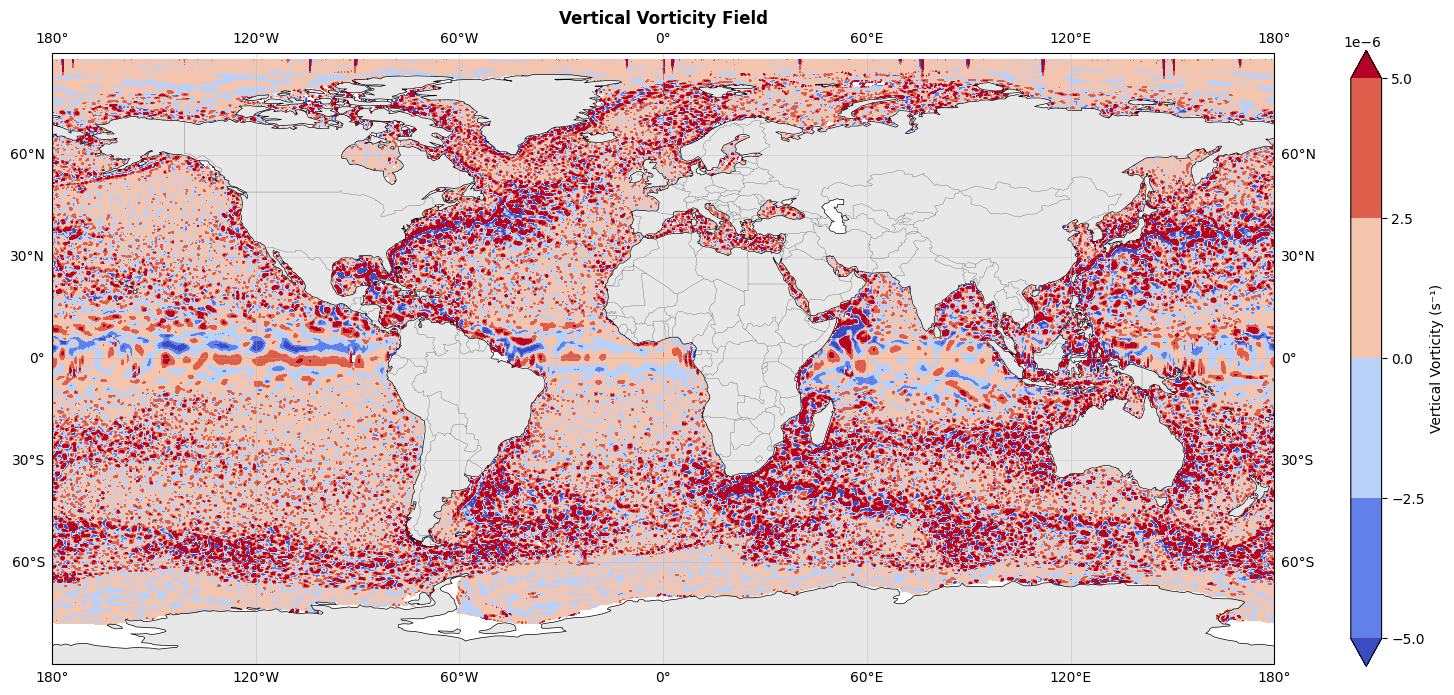

In [5]:
# Visualize vorticity field with smooth contours
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Use filled contours for smooth blob visualization
vort_data = vorticity.values.T
levels = np.linspace(-5e-6, 5e-6, 5)
cf = ax.contourf(
    lons, lats, vort_data,
    levels=levels,
    cmap='coolwarm',
    transform=ccrs.PlateCarree(),
    extend='both'
)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)

# Colorbar
cbar = plt.colorbar(cf, ax=ax, shrink=0.8, pad=0.05)
cbar.set_label('Vertical Vorticity (s⁻¹)', fontsize=10)
ax.set_title('Vertical Vorticity Field',
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

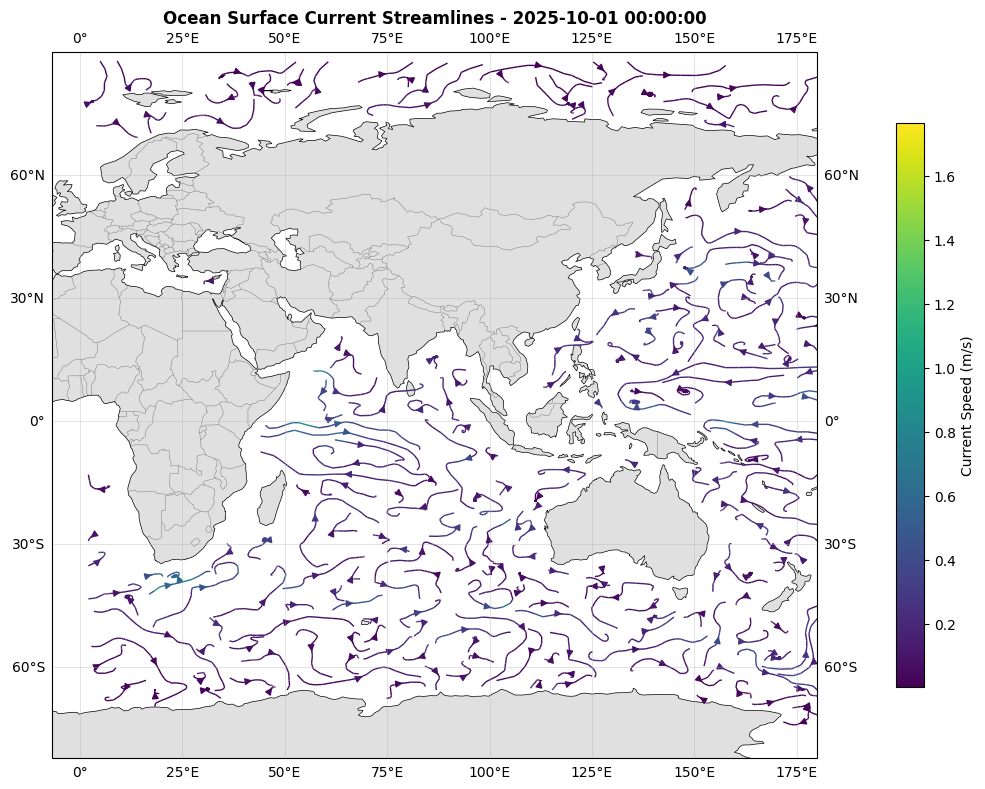

In [ ]:
# Streamplot of velocity field
time_idx = -1  # latest time step
u_data = currents_ds['ug'].isel(time=time_idx).values.T
v_data = currents_ds['vg'].isel(time=time_idx).values.T

# Calculate speed for color mapping
speed = np.sqrt(u_data**2 + v_data**2)

fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Create streamplot
stream = ax.streamplot(
    lons, lats, u_data, v_data,
    color=speed,
    cmap='viridis',
    density=3,
    linewidth=1.0,
    arrowsize=1.0,
    transform=ccrs.PlateCarree()
)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)

# Colorbar
cbar = plt.colorbar(stream.lines, ax=ax, shrink=0.8, pad=0.05)
cbar.set_label('Current Speed (m/s)', fontsize=10)
ax.set_title(f'Ocean Surface Current Streamlines',
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [7]:
# # Visualize Okubo-Weiss parameter with smooth contours
# fig = plt.figure(figsize=(16, 8))
# ax = plt.axes(projection=ccrs.PlateCarree())

# # Use filled contours for smooth blob visualization
# ow_data = okubo_weiss.values.T
# levels = np.linspace(-1e-10, 1e-10, 5)  # More levels for smoother appearance
# cf = ax.contourf(
#     lons, lats, ow_data,
#     levels=levels,
#     cmap='bwr',
#     transform=ccrs.PlateCarree(),
#     extend='both'
# )

# # Add geographic features
# ax.coastlines(linewidth=0.5)
# ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)
# ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)

# # Colorbar
# cbar = plt.colorbar(cf, ax=ax, shrink=0.8, pad=0.05)
# cbar.set_label('Okubo-Weiss Parameter (s⁻²)', fontsize=10)
# ax.set_title('Okubo-Weiss Parameter',
#              fontsize=12, fontweight='bold')

# plt.tight_layout()
# plt.show()